# Phase 3: XY Registration (Clean Version)

Match vessel bifurcations between volumes to calculate XY translation.

## Workflow:
1. Load bifurcations from both volumes
2. Match corresponding points using nearest neighbor + RANSAC
3. Calculate robust XY translation offset
4. Apply and visualize alignment
5. Save registration parameters

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import cdist
from sklearn.linear_model import RANSACRegressor
from scipy.ndimage import shift

data_dir = Path('data')
print("✓ Imports complete")

✓ Imports complete


## Step 1: Load Data

Loaded data:
  Volume 0: 2094 bifurcations, skeleton (1216, 1216)
  Volume 1: 5539 bifurcations, skeleton (1216, 1216)


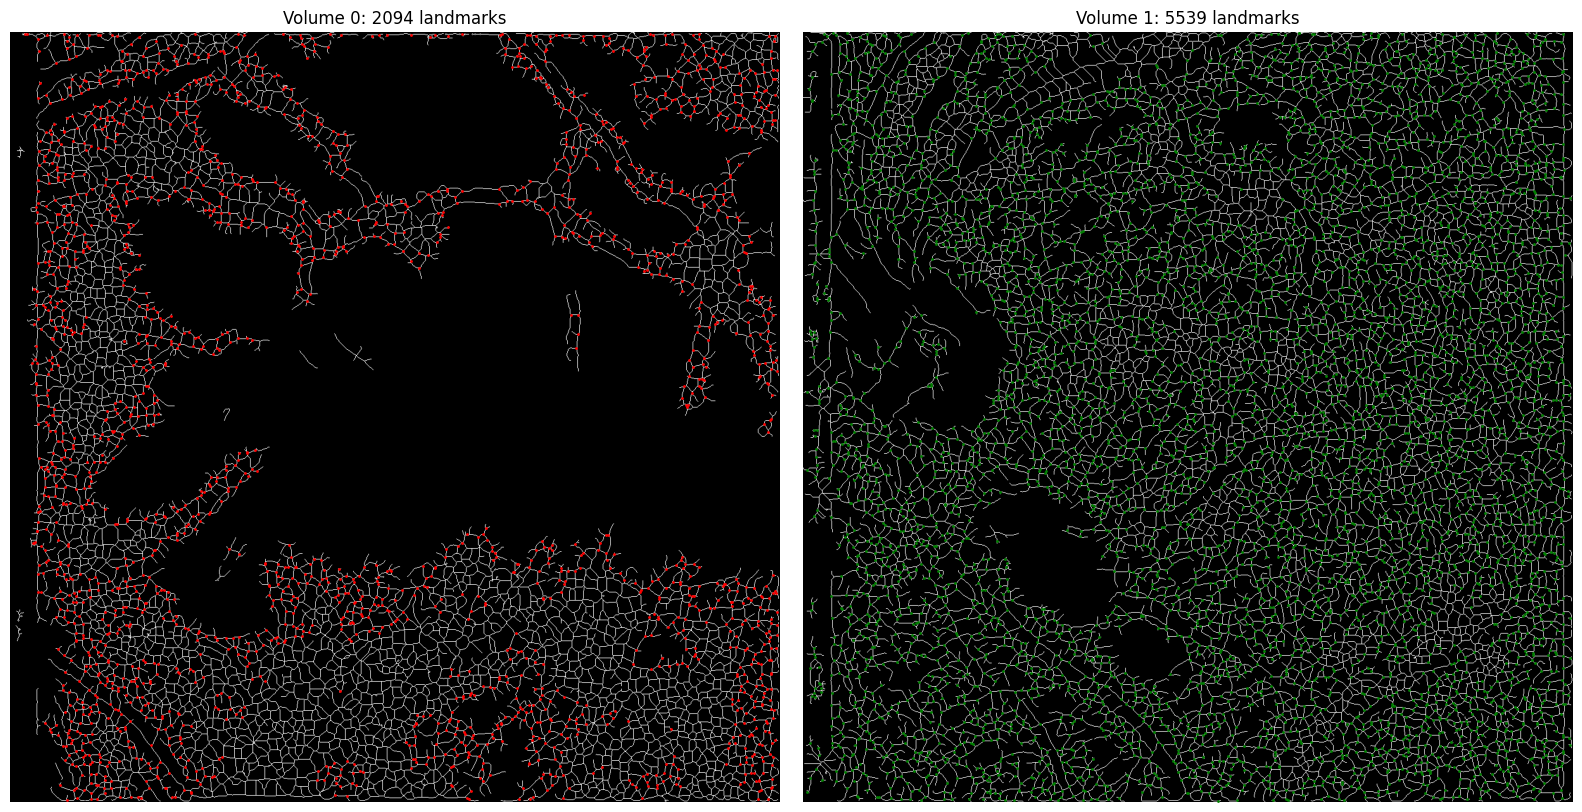

In [2]:
# Load bifurcations and skeletons
bif_v0 = np.load(data_dir / 'bifurcation_coords_volume0.npy')
bif_v1 = np.load(data_dir / 'bifurcation_coords_volume1.npy')
skel_v0 = np.load(data_dir / 'vessel_skeleton_volume0.npy')
skel_v1 = np.load(data_dir / 'vessel_skeleton_volume1.npy')

print(f"Loaded data:")
print(f"  Volume 0: {len(bif_v0)} bifurcations, skeleton {skel_v0.shape}")
print(f"  Volume 1: {len(bif_v1)} bifurcations, skeleton {skel_v1.shape}")

# Visualize initial state
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(skel_v0, cmap='gray')
axes[0].plot(bif_v0[:, 1], bif_v0[:, 0], 'r.', markersize=2)
axes[0].set_title(f'Volume 0: {len(bif_v0)} landmarks')
axes[0].axis('off')

axes[1].imshow(skel_v1, cmap='gray')
axes[1].plot(bif_v1[:, 1], bif_v1[:, 0], 'g.', markersize=2)
axes[1].set_title(f'Volume 1: {len(bif_v1)} landmarks')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 2: Match Bifurcations with RANSAC

In [3]:
def match_bifurcations_ransac(src, dst, max_distance=100, min_samples=20):
    """Match bifurcations using nearest neighbor + RANSAC."""
    # Find nearest neighbors
    distances = cdist(src, dst)
    nearest_idx = np.argmin(distances, axis=1)
    nearest_dist = np.min(distances, axis=1)
    
    # Filter by distance
    valid = nearest_dist < max_distance
    src_matched = src[valid]
    dst_matched = dst[nearest_idx[valid]]
    
    print(f"Initial matches: {len(src_matched)}")
    
    if len(src_matched) < min_samples:
        return None, None, None
    
    # Calculate displacement vectors
    displacements = dst_matched - src_matched
    
    # RANSAC to find inliers
    ransac_y = RANSACRegressor(random_state=42, min_samples=min_samples)
    ransac_x = RANSACRegressor(random_state=42, min_samples=min_samples)
    
    X = np.arange(len(displacements)).reshape(-1, 1)
    ransac_y.fit(X, displacements[:, 0])
    ransac_x.fit(X, displacements[:, 1])
    
    inlier_mask = ransac_y.inlier_mask_ & ransac_x.inlier_mask_
    translation = np.median(displacements[inlier_mask], axis=0)
    
    print(f"RANSAC inliers: {inlier_mask.sum()} / {len(inlier_mask)}")
    print(f"Translation (dy, dx): ({translation[0]:.2f}, {translation[1]:.2f}) pixels")
    
    matches = np.column_stack([np.where(valid)[0], nearest_idx[valid]])
    return translation, inlier_mask, matches

# Perform matching
translation, inlier_mask, matches = match_bifurcations_ransac(bif_v1, bif_v0)

Initial matches: 5061
RANSAC inliers: 1696 / 5061
Translation (dy, dx): (0.00, 0.00) pixels


## Step 3: Visualize Matches

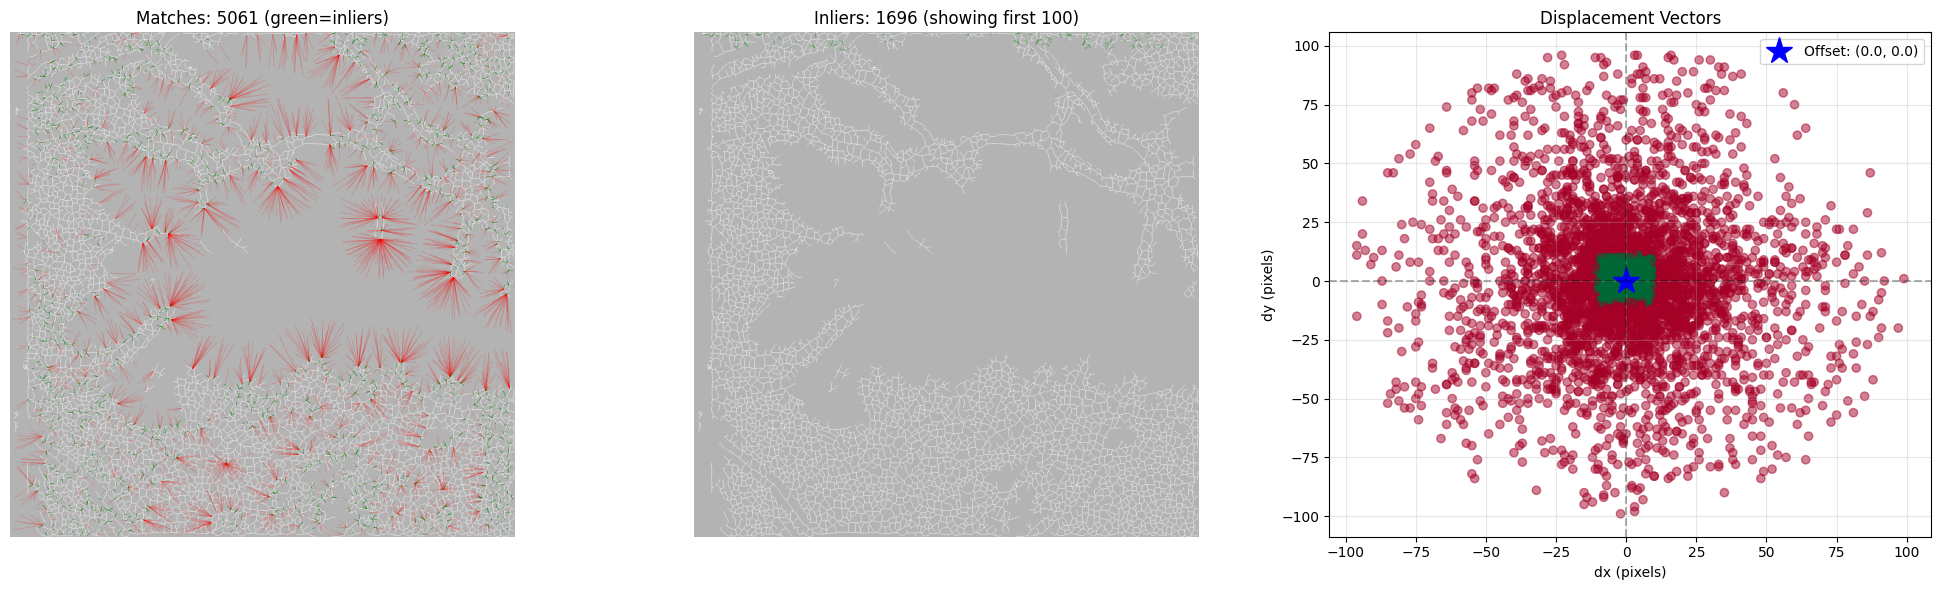

In [4]:
if translation is not None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # All matches
    axes[0].imshow(skel_v0, cmap='gray', alpha=0.3)
    for i, (src_idx, dst_idx) in enumerate(matches):
        color = 'g' if inlier_mask[i] else 'r'
        alpha = 0.6 if inlier_mask[i] else 0.2
        axes[0].plot([bif_v1[src_idx, 1], bif_v0[dst_idx, 1]], 
                     [bif_v1[src_idx, 0], bif_v0[dst_idx, 0]], 
                     color=color, alpha=alpha, linewidth=0.5)
    axes[0].set_title(f'Matches: {len(matches)} (green=inliers)')
    axes[0].axis('off')
    
    # Inliers only
    axes[1].imshow(skel_v0, cmap='gray', alpha=0.3)
    inlier_matches = matches[inlier_mask]
    for src_idx, dst_idx in inlier_matches[:100]:
        axes[1].plot([bif_v1[src_idx, 1], bif_v0[dst_idx, 1]], 
                     [bif_v1[src_idx, 0], bif_v0[dst_idx, 0]], 
                     'g-', alpha=0.3, linewidth=1)
    axes[1].set_title(f'Inliers: {inlier_mask.sum()} (showing first 100)')
    axes[1].axis('off')
    
    # Displacement distribution
    displacements = bif_v0[matches[:, 1]] - bif_v1[matches[:, 0]]
    axes[2].scatter(displacements[:, 1], displacements[:, 0], 
                   c=inlier_mask, cmap='RdYlGn', alpha=0.5)
    axes[2].plot(translation[1], translation[0], 'b*', markersize=20, 
                label=f'Offset: ({translation[0]:.1f}, {translation[1]:.1f})')
    axes[2].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[2].axvline(0, color='k', linestyle='--', alpha=0.3)
    axes[2].set_xlabel('dx (pixels)')
    axes[2].set_ylabel('dy (pixels)')
    axes[2].set_title('Displacement Vectors')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 4: Apply Registration

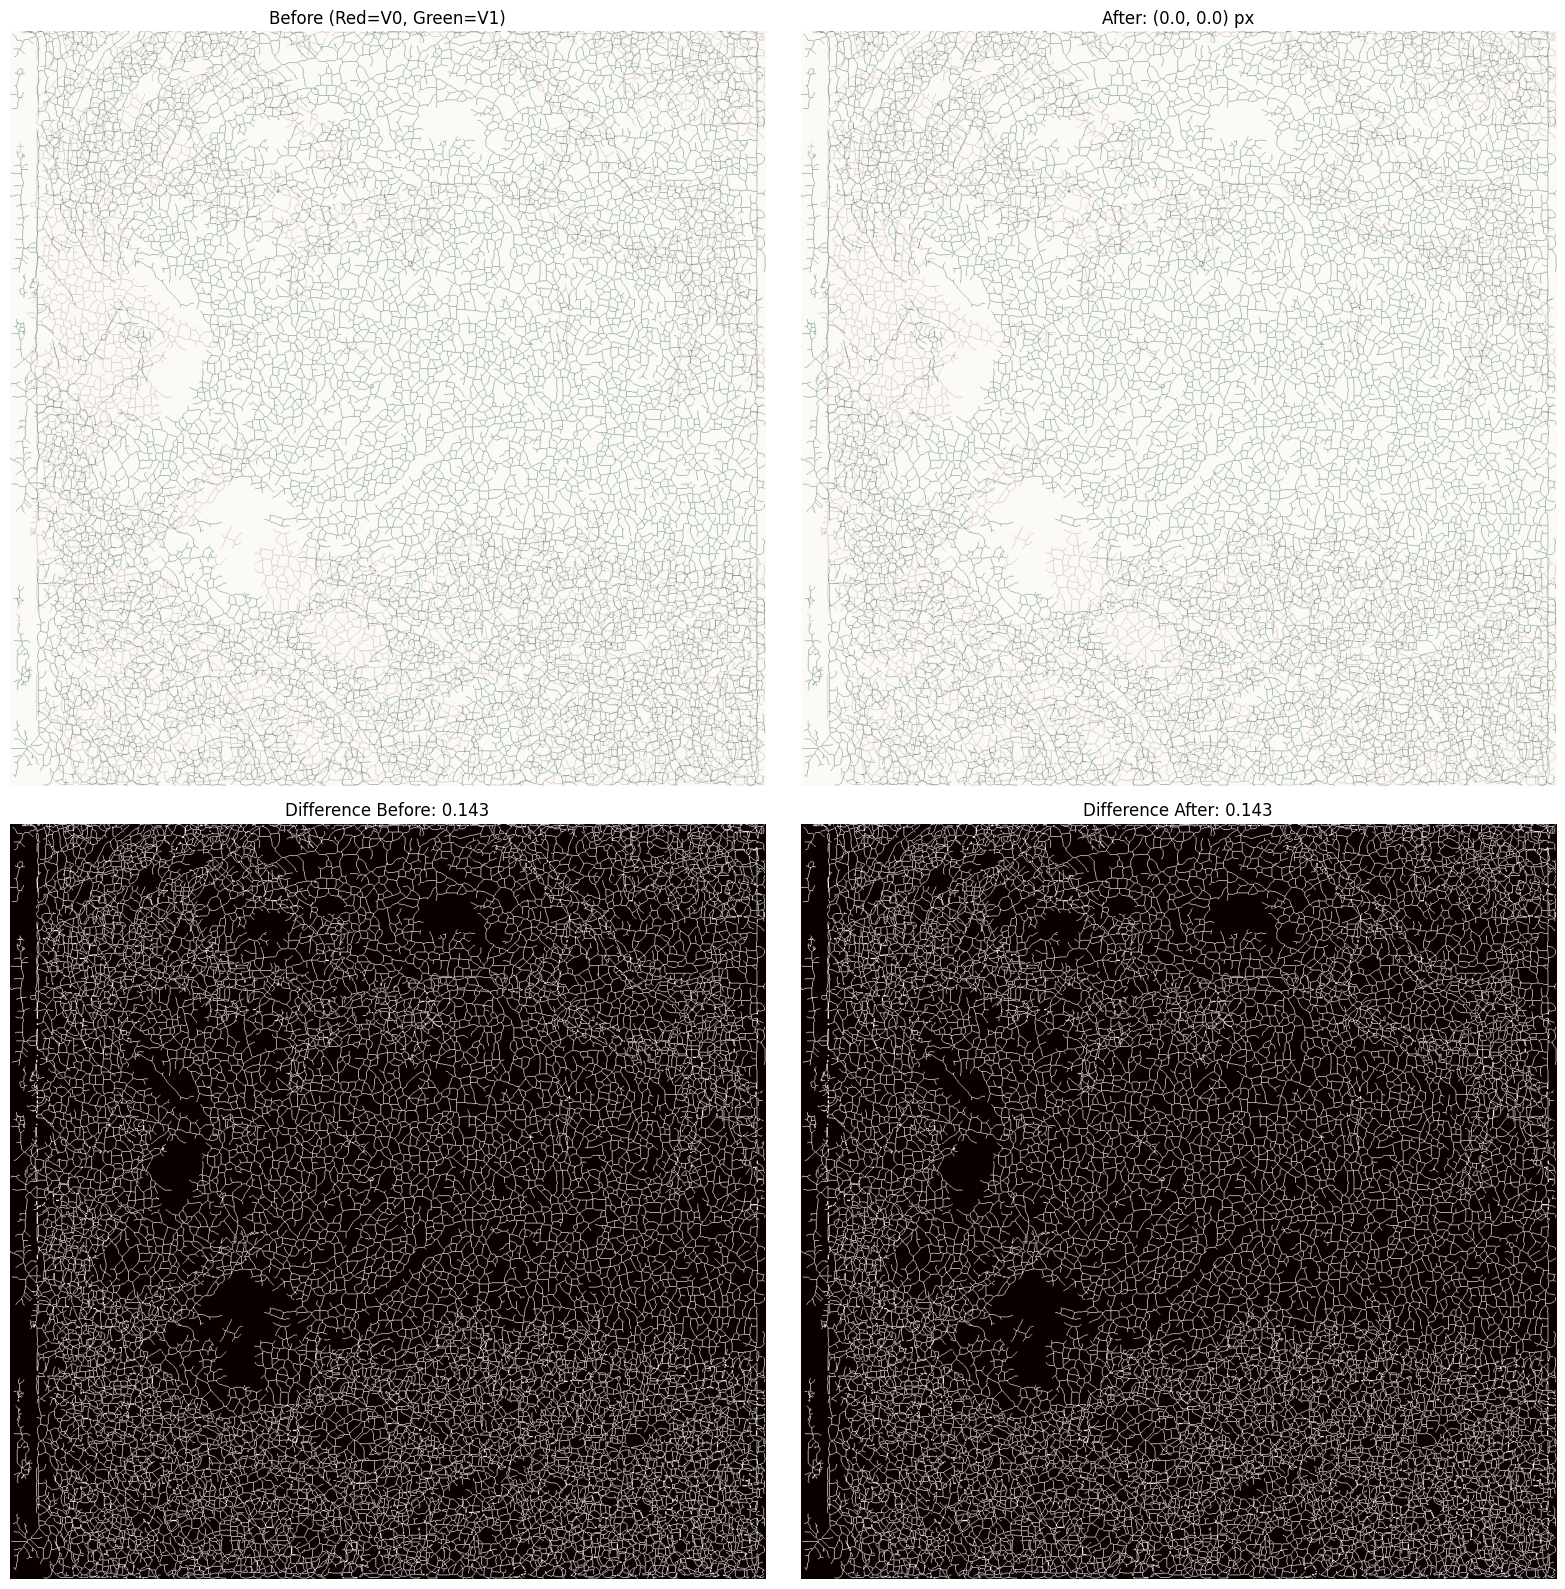


Alignment Quality:
  Before: 0.1432
  After: 0.1432
  Improvement: 0.0%


In [5]:
if translation is not None:
    # Apply translation
    skel_v1_aligned = shift(skel_v1, shift=translation, order=0, mode='constant', cval=0)
    bif_v1_aligned = bif_v1 + translation
    
    # Visualize before/after
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Before
    axes[0, 0].imshow(skel_v0, cmap='Reds', alpha=0.5)
    axes[0, 0].imshow(skel_v1, cmap='Greens', alpha=0.5)
    axes[0, 0].set_title('Before (Red=V0, Green=V1)')
    axes[0, 0].axis('off')
    
    # After
    axes[0, 1].imshow(skel_v0, cmap='Reds', alpha=0.5)
    axes[0, 1].imshow(skel_v1_aligned, cmap='Greens', alpha=0.5)
    axes[0, 1].set_title(f'After: ({translation[0]:.1f}, {translation[1]:.1f}) px')
    axes[0, 1].axis('off')
    
    # Difference before/after
    diff_before = np.abs(skel_v0.astype(float) - skel_v1.astype(float))
    diff_after = np.abs(skel_v0.astype(float) - skel_v1_aligned.astype(float))
    
    axes[1, 0].imshow(diff_before, cmap='hot')
    axes[1, 0].set_title(f'Difference Before: {diff_before.mean():.3f}')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(diff_after, cmap='hot')
    axes[1, 1].set_title(f'Difference After: {diff_after.mean():.3f}')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAlignment Quality:")
    print(f"  Before: {diff_before.mean():.4f}")
    print(f"  After: {diff_after.mean():.4f}")
    print(f"  Improvement: {100*(1 - diff_after.mean()/diff_before.mean()):.1f}%")

## Step 5: Save Results

In [6]:
if translation is not None:
    # Save registration parameters
    params = {
        'translation_yx': translation.tolist(),
        'num_matches': len(matches),
        'num_inliers': int(inlier_mask.sum()),
        'inlier_ratio': float(inlier_mask.sum() / len(matches)),
        'mean_diff_before': float(diff_before.mean()),
        'mean_diff_after': float(diff_after.mean())
    }
    
    np.save(data_dir / 'xy_registration_params.npy', params)
    np.save(data_dir / 'skeleton_v1_aligned.npy', skel_v1_aligned)
    np.save(data_dir / 'bifurcations_v1_aligned.npy', bif_v1_aligned)
    
    print("✓ Saved results:")
    print("  - xy_registration_params.npy")
    print("  - skeleton_v1_aligned.npy")
    print("  - bifurcations_v1_aligned.npy")
    print(f"\n✓ Phase 3 complete! Ready for Phase 4 (depth alignment).")

✓ Saved results:
  - xy_registration_params.npy
  - skeleton_v1_aligned.npy
  - bifurcations_v1_aligned.npy

✓ Phase 3 complete! Ready for Phase 4 (depth alignment).
